In [2]:
from __future__ import division
from __future__ import print_function
from collections import namedtuple
import datetime
import dateutil.parser
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import pandas.io.gbq
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
import keras
from keras.models import Sequential, Model as KerasModel
from keras.layers import Dense, Dropout, Flatten, MaxoutDense, LeakyReLU, ELU, Input
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.core import Activation
from keras import backend as K
from keras.engine.topology import Layer
from keras import optimizers
assert K.image_data_format() == 'channels_last'
%matplotlib inline

# This is a DAGEROUS workaround to having two KMP libraries linked
# Would be better to figure out conflict
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

assert K.image_data_format() == 'channels_last'
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from encounters_model import longline_data
from encounters_model import util
from encounters_model.util import minute, hour

Using TensorFlow backend.


In [397]:
# Step 1. Figure out where we are going to get the train and test data
# Break up by boat – if we validate using the same boat validated by
# two different people it will wildly optimistic

paths = sorted((glob("../../birdlife/labeled_data/without_logbook_data/*.json") +
                glob("../../birdlife/labeled_data/with_logbook_data/*.json")))

all_paths = paths + glob("../../birdlife/unlabelled_data/*.json") + glob("../../birdlife/allboats/*.json")

In [126]:
with open(
    '../../birdlife/labeled_data/without_logbook_data/431704220_2017_8_2_David_2018-08-15T20_08_26.194Z.json') as f:
          obj = json.load(f)

In [178]:
print(','.join([r"\'{}\'".format(x) for x in ssvid]))

\'432298000\',\'431704220\',\'432298000\',\'416004865\',\'416002616\',\'416002616\',\'416085700\',\'416002659\',\'416768000\',\'416002659\',\'432298000\',\'416002616\',\'416085700\',\'416874000\',\'416826000\',\'416768000\',\'416874000\',\'416826000\',\'416005500\',\'416005500\',\'416002659\',\'416826000\',\'431704220\',\'416002616\',\'416005500\',\'659283000\',\'601061600\',\'659283000\',\'601061600\',\'659283000\',\'601274700\',\'659283000\',\'601061600\',\'601274700\',\'601274700\',\'601061600\',\'601274700\'


In [150]:
(all_features.ssvid == '431704220').sum()

1488

In [251]:
ssvid = sorted(set([os.path.basename(x).split('_')[0] for x in paths]))
ssvid

['416002616',
 '416002659',
 '416004865',
 '416005500',
 '416085700',
 '416768000',
 '416826000',
 '416874000',
 '431704220',
 '432298000',
 '601061600',
 '601274700',
 '659283000']

In [233]:
query = '''
with counted as (
select 
  ssvid,
  vessel_id,
  sum(pos_count) over (partition by ssvid) as count
from `world-fishing-827.pipe_production_b.segment_identity_2017*`
where _table_suffix between '0601' and '0831'
and ssvid in ({})
),

ranked as (
select
  ssvid, 
  vessel_id,
  row_number() over (partition by ssvid order by count desc) as rk
from counted
),

ssvid_to_vid as (
SELECT ssvid, vessel_id 
from  ranked
where rk = 1
)

select * from 
(select * from `machine_learning_dev_ttl_120d.test_loitering_features2017*`
where _table_suffix between '0601' and '0831') features
join
ssvid_to_vid 
on (features.id = ssvid_to_vid.vessel_id)
'''.format(
','.join(['"{}"'.format(x) for x in ssvid])
)
print(query)
# where timestamp_trunc(timestamp, hour) = timestamp




with counted as (
select 
  ssvid,
  vessel_id,
  sum(pos_count) over (partition by ssvid) as count
from `world-fishing-827.pipe_production_b.segment_identity_2017*`
where _table_suffix between '0601' and '0831'
and ssvid in ("432298000","431704220","432298000","416004865","416002616","416002616","416085700","416002659","416768000","416002659","432298000","416002616","416085700","416874000","416826000","416768000","416874000","416826000","416005500","416005500","416002659","416826000","431704220","416002616","416005500","659283000","601061600","659283000","601061600","659283000","601274700","659283000","601061600","601274700","601274700","601061600","601274700")
),

ranked as (
select
  ssvid, 
  vessel_id,
  row_number() over (partition by ssvid order by count desc) as rk
from counted
),

ssvid_to_vid as (
SELECT ssvid, vessel_id 
from  ranked
where rk = 1
)

select * from 
(select * from `machine_learning_dev_ttl_120d.test_loitering_features2017*`
where _table_suffix between '0601' 

In [352]:
query = '''
select * from 
(select id as ssvid, * from `machine_learning_dev_ttl_120d.test_loitering_features_mmsi_2_2017*`
) features
where 
ssvid in ({})
order by timestamp
'''.format(
','.join(['"{}"'.format(x) for x in ssvid])
)
# and timestamp_trunc(timestamp, hour) = timestamp
print(query)


select * from 
(select id as ssvid, * from `machine_learning_dev_ttl_120d.test_loitering_features_mmsi_2_2017*`
) features
where 
ssvid in ("416002616","416002659","416004865","416005500","416085700","416768000","416826000","416874000","431704220","432298000","601061600","601274700","659283000")
order by timestamp



In [353]:
all_features = pd.read_gbq(query, project_id='world-fishing-827', dialect='standard')

In [354]:
an_ssvid = ssvid[0]
mask = all_features.ssvid == an_ssvid
some_features = all_features[mask]
some_features = some_features.sort_values(by='timestamp')

In [355]:
len(set(all_features.ssvid)) # 11 # 12

13

## Compare Precomputed to Existing Features

601061600_2017_8_1_Nate_2018-08-13T21_37_01.936Z 601061600


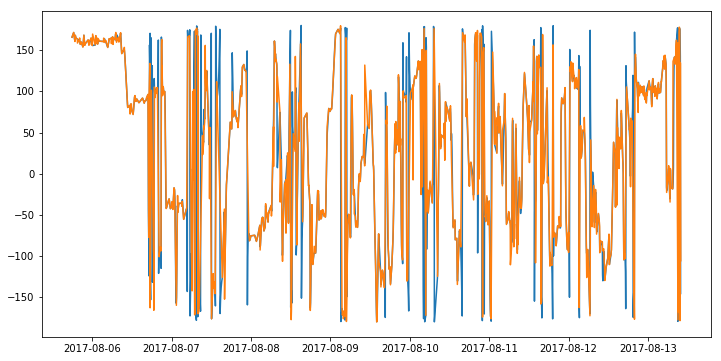

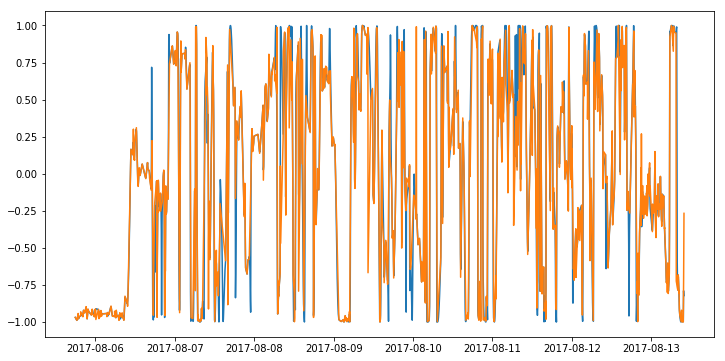

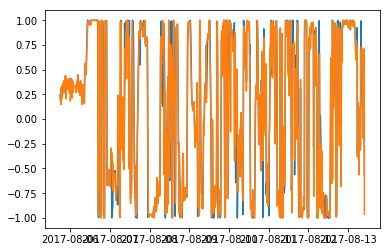

In [412]:
def compare(p):
    name = os.path.splitext(os.path.basename(p))[0]
    id_ = name.split('_')[0]
    print(name, id_)
    with open(p) as f:
      obj = json.load(f)
    timestamps = [dateutil.parser.parse(x) for x in obj['timestamps']]
    t0 = timestamps[0]
    t1 = timestamps[-1]
    mask = (all_features.id == id_) & (all_features.timestamp >= t0) & (all_features.timestamp <= t1)
    df = all_features[mask].copy()
    obj['timestamp'] = obj['timestamps']
    longline_data.add_obj_data(pd.DataFrame({'timestamp' : timestamps,
                                             'fishing' : obj['fishing']}), df)
#     plt.plot(df.timestamp, df.lat)
#     plt.plot(timestamps, obj['lats'])
#     plt.show()
#     plt.plot(df.timestamp, df.lon)
#     plt.plot(timestamps, obj['lons'])
#     plt.show()
#     plt.plot(df.timestamp, df.speed_knots)
#     plt.plot(timestamps, obj['sogs'])
#     plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(df.timestamp, (df.course_degrees + 180) % 360 - 180)
    plt.plot(timestamps, [(x + 180) % 360 - 180 for x in obj['courses']])

    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(df.timestamp, np.cos(np.radians(df.course_degrees)))
    plt.plot(timestamps, [np.cos(np.radians(x)) for x in obj['courses']])
    plt.show()
    plt.plot(df.timestamp, np.sin(np.radians(df.course_degrees)))
    plt.plot(timestamps, [np.sin(np.radians(x)) for x in obj['courses']])
    plt.show()
#     plt.plot(df.timestamp, df.is_fishing)
#     plt.plot(timestamps, [x == 1 for x in obj['fishing']])
#     plt.show()   
#     plt.plot(df.timestamp, df.is_defined)
#     plt.plot(timestamps, [x != 0 for x in obj['fishing']])
#     plt.show() 
compare(paths[1])

In [300]:
len(all_features) # 98299 # 1345887

1345887

In [416]:
import imp, encounters_model.longline_sets_models, encounters_model.longline_data
imp.reload(encounters_model.longline_sets_models)
imp.reload(encounters_model.longline_data)
imp.reload(encounters_model.util)
from encounters_model.longline_sets_models import ConvNetModel5
keep_fracs = [1, 0.75, 0.5, 0.25]

mdl = ConvNetModel5()

# times, features, labels, _, defined = encounters_model.longline_data.generate_data(
#     paths, min_samples=1000, window=mdl.window, delta=mdl.delta, keep_fracs=keep_fracs, force_local=False, 
#     precomp_features=all_features)

In [ ]:
len(features) # 20336 # 20992

## Old data

In [174]:
mdl.fit(features, labels, epochs=1, 
        sample_weight=defined, validation_split=0.2, batch_size=batch_size)

Train on 19417 samples, validate on 4855 samples
Epoch 1/30
19417/19417 [==============================] - 27s 1ms/step - loss: 0.8088 - acc: 0.4619 - val_loss: nan - val_acc: 0.4762
Epoch 2/30
19417/19417 [==============================] - 14s 729us/step - loss: 0.6392 - acc: 0.4907 - val_loss: nan - val_acc: 0.6803
Epoch 3/30
19417/19417 [==============================] - 14s 734us/step - loss: 0.5368 - acc: 0.5226 - val_loss: nan - val_acc: 0.6243
Epoch 4/30
19417/19417 [==============================] - 14s 743us/step - loss: 0.4816 - acc: 0.5467 - val_loss: nan - val_acc: 0.6344
Epoch 5/30
19417/19417 [==============================] - 15s 749us/step - loss: 0.4270 - acc: 0.5538 - val_loss: nan - val_acc: 0.6070
Epoch 6/30
19417/19417 [==============================] - 15s 750us/step - loss: 0.3917 - acc: 0.5707 - val_loss: nan - val_acc: 0.6486
Epoch 7/30
 8192/19417 [===========>..................] - ETA: 7s - loss: 0.3423 - acc: 0.5687

KeyboardInterrupt: 

In [10]:
imp.reload(util)

<module 'encounters_model.util' from '/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/transshipment-analysis/encounters_model/encounters_model/util.py'>

In [430]:
import imp, encounters_model.longline_sets_models, encounters_model.longline_data
imp.reload(encounters_model.longline_sets_models)
imp.reload(encounters_model.longline_data)
imp.reload(encounters_model.util)
from encounters_model.longline_sets_models import ConvNetModel5
max_epochs = 20

f1_scores = []
class_b_f1_scores = []
david_class_b_f1_scores = []

def test_model(mdl, test_sets, min_samples, keep_frac=1.0):
    times, features, labels, _, defined = longline_data.generate_data(test_sets, window=mdl.window, delta=mdl.delta, 
                                               min_samples=1000, keep_fracs=(keep_frac,), noise=0,
                                               precomp_features=all_features)
    predictions = mdl.predict(features)
    print("model accuracy:", accuracy_score(labels, predictions, sample_weight=defined))
    precision, recall, fscore, support = precision_recall_fscore_support(labels, predictions, sample_weight=defined)
    print("model precision:", precision[1])
    print("model recall:", recall[1])
    print("model f1-score:", fscore[1])
    print("model set support:", support[1])
    print()
    return fscore
    

data_sets = paths

    
folder = KFold(n_splits=5, random_state=888, shuffle=True)
all_agreements = {}
for i, (train_index, test_index) in enumerate(folder.split(data_sets)):
    print("Fold", i)
    data_sets_array = np.asarray(data_sets)
    train_sets = data_sets_array[train_index]
    test_sets = data_sets_array[test_index]
    print(test_sets)
    
    # Train the model
    print('generating data')
    xtimes, xfeatures, xlabels, _, xdefined = longline_data.generate_data(train_sets, min_samples=1000, 
                                                                        window=mdl.window, delta=mdl.delta, 
                                                                        keep_fracs=keep_fracs,
                                                                       force_local=True, 
                                                                          precomp_features=all_features)
    print('training')
    mdl = ConvNetModel5().fit(xfeatures, xlabels, epochs=max_epochs, 
                              sample_weight=xdefined, batch_size=batch_size)

    
    # Test the model
    print('testing')
    fscore = test_model(mdl, test_sets, min_samples=1000)
    f1_scores.append(fscore[1])

        
print("Score derived from random sampling:")
print("  Average F1-Score:", np.mean(f1_scores))
# Score derived from random sampling:
#   Average F1-Score: 0.9017776697730765 # No dist / 5
# Score derived from random sampling:
#   Average F1-Score: 0.9025109925385859 # dist / 5
# Score derived from random sampling: # dist / 20
#   Average F1-Score: 0.9000099069510276
# Score derived from random sampling: # dist / 20 / fracs
#   Average F1-Score: 0.9153510210274121

Fold 0
['../../birdlife/labeled_data/with_logbook_data/659283000_2017_7_2_Steph_2018-08-14T15_06_59.911Z.json'
 '../../birdlife/labeled_data/without_logbook_data/416002616_2017_8_1_Steph_2018-08-20T14_17_43.647Z.json'
 '../../birdlife/labeled_data/without_logbook_data/416005500_2017_7_1_Nate_2018-08-19T23_32_12.247Z.json'
 '../../birdlife/labeled_data/without_logbook_data/416085700_2017_8_1_David_2018-08-15T19_49_21.604Z.json'
 '../../birdlife/labeled_data/without_logbook_data/416826000_2017_9_1_David_2018-08-16T23_45_38.838Z.json'
 '../../birdlife/labeled_data/without_logbook_data/416874000_2017_7_1_Nate_2018-08-18T20_39_38.239Z.json'
 '../../birdlife/labeled_data/without_logbook_data/432298000_2017_9_1_David_2018-08-21T08_05_28.921Z.json'
 '../../birdlife/labeled_data/without_logbook_data/432298000_2017_9_1_Nate_2018-08-21T17_58_06.641Z.json']
generating data
training
Epoch 1/20
21576/21576 [==============================] - 74s 3ms/step - loss: 0.1723 - acc: 0.8685
Epoch 2/20
21576/

21960/21960 [==============================] - 17s 774us/step - loss: 0.0221 - acc: 0.9142
Epoch 13/20
21960/21960 [==============================] - 17s 781us/step - loss: 0.0217 - acc: 0.9209
Epoch 14/20
21960/21960 [==============================] - 17s 774us/step - loss: 0.0194 - acc: 0.9248
Epoch 15/20
21960/21960 [==============================] - 17s 775us/step - loss: 0.0201 - acc: 0.9322
Epoch 16/20
21960/21960 [==============================] - 17s 771us/step - loss: 0.0206 - acc: 0.9244
Epoch 17/20
21960/21960 [==============================] - 17s 780us/step - loss: 0.0160 - acc: 0.9306
Epoch 18/20
21960/21960 [==============================] - 17s 777us/step - loss: 0.0149 - acc: 0.9315
Epoch 19/20
21960/21960 [==============================] - 17s 775us/step - loss: 0.0174 - acc: 0.9345
Epoch 20/20
21960/21960 [==============================] - 17s 779us/step - loss: 0.0133 - acc: 0.9342
testing
model accuracy: 0.9427947598253276
model precision: 0.8683333333333333
model 

In [431]:
# Train the model on all of the data
times, features, labels, _, defined = encounters_model.longline_data.generate_data(data_sets, min_samples=1000, 
                                                                          window=mdl.window, 
                                           delta=mdl.delta, keep_fracs=keep_fracs, precomp_features=all_features)
mdl_all = ConvNetModel5().fit(features, labels, epochs=20)

Epoch 1/20
24272/24272 [==============================] - 165s 7ms/step - loss: 0.2035 - acc: 0.9225
Epoch 2/20
24272/24272 [==============================] - 48s 2ms/step - loss: 0.1263 - acc: 0.9513
Epoch 3/20
24272/24272 [==============================] - 47s 2ms/step - loss: 0.1041 - acc: 0.9602
Epoch 4/20
24272/24272 [==============================] - 48s 2ms/step - loss: 0.0902 - acc: 0.9642
Epoch 5/20
24272/24272 [==============================] - 50s 2ms/step - loss: 0.0789 - acc: 0.9697
Epoch 6/20
24272/24272 [==============================] - 51s 2ms/step - loss: 0.0739 - acc: 0.9705
Epoch 7/20
24272/24272 [==============================] - 54s 2ms/step - loss: 0.0679 - acc: 0.9734
Epoch 8/20
24272/24272 [==============================] - 71s 3ms/step - loss: 0.0656 - acc: 0.9741
Epoch 9/20
24272/24272 [==============================] - 77s 3ms/step - loss: 0.0596 - acc: 0.9773
Epoch 10/20
24272/24272 [==============================] - 77s 3ms/step - loss: 0.0585 - acc: 0.976

1. (X) Train on all.
2. (X) Save as h5 file
3. (X) Get standalone working.
4. ( ) Run features for all of 2017
5. ( ) Copy run iference using the Keras version -- should be easier!
6. ( ) Run on all longliners for 2017.
7. ( ) Have someone spot check.
8. ( ) Copy over to loitering.

In [432]:
# mdl_all.save('longline_model_precomp.h5')

In [280]:
base_model.hybrid_pool_layer

<function test_package.base_model.hybrid_pool_layer(x, pool_size=2)>

In [210]:
from ll_sets import util, base_model, longline_sets_models
imp.reload(util)
imp.reload(base_model)
imp.reload(longline_sets_models)
# from encounters_model.longline_sets_models import ConvNetModel5
# mdl_reload2 = ConvNetModel5.load('longline_model.h5')
import ll_sets.longline_sets_models
mdl_reload = ll_sets.longline_sets_models.ConvNetModel5.load('longline_model_precomp.h5')



In [226]:
# mdl_reload = ConvNetModel5.load('longline_model/model.h5')

# import h5py
# # >>> f = h5py.File('myfile.hdf5','r')


# # with zipfile.ZipFile('test_zip.zip', 'w') as zf:
# #     with zf.open('norm.npz', 'w') as f:
# #         mdl_all.normalizer.save(f)
# #     with zf.open('model.h5', 'w') as pyf:
# #         h5f = h5py.File(pyf, 'w')
# #         mdl_all.model.save(h5f)

# with h5py.File('longline_model/model.h5', 'r+') as f:
#     if 'normalizer' not in f.keys():
#         f.create_dataset('normalizer', [])
#     f['normalizer'].attrs['mean'] = mdl_all.normalizer.mean
#     f['normalizer'].attrs['std'] = mdl_all.normalizer.std
#     print(list(f.keys()))

In [227]:
# mdl_reload.save('longline_model.h5')

In [228]:
# imp.reload(util)
# imp.reload(encounters_model.longline_sets_models)
# imp.reload(encounters_model.longline_data)
# imp.reload(encounters_model.predict_longline_setting)
# mdl_reload2 = ConvNetModel5.load('longline_model.h5')

In [ ]:
from collections import namedtuple

## Load Birdlife Ranges

In [2]:
birdlife_ranges_df = pd.read_csv('birdlife_training_ranges.csv')

In [3]:
query_template = """\
select ssvid as mmsi, lat, lon, timestamp, course, speed
from `gfw_research.pipe_production_b_fishing`
where date(_partitiontime) between date("{:%Y-%m-%d}") and date("{:%Y-%m-%d}")
and ssvid in ({})
order by timestamp"""

query = query_template.format(dateutil.parser.parse(birdlife_ranges_df.first_time.min()),
                              dateutil.parser.parse(birdlife_ranges_df.last_time.max()), 
                              ','.join(['"{}"'.format(x) for x in birdlife_ranges_df.mmsi]))
birdlife_data_df = pd.read_gbq(query, project_id='world-fishing-827', dialect='standard')

//anaconda/envs/p3ml/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:

def process_bq_data(data_df, ranges_df):
    mask = ~data_df.speed.isnull() & ~data_df.course.isnull()
    data_df = data_df[mask]
    ranges = []
    for x in ranges_df.itertuples():
        mmsi = str(x.mmsi)
        mask = ((x.first_time <= data_df.timestamp) & 
                (data_df.timestamp <= x.last_time) &
                (data_df.mmsi == mmsi)
               )
        data = data_df[mask]
        ranges.append({
            'mmsi' : mmsi,
            'path' : x.path,
            'timestamps' : [x.to_pydatetime(x) for x in data.timestamp],
            'lats' : data.lat.values,
            'lons' : data.lon.values,
            'sogs' : data.speed.values,
            'courses' : data.course.values,
            'data' : data.copy()
        })
    return ranges

birdlife_ais_data = process_bq_data(birdlife_data_df, birdlife_ranges_df)

In [5]:
# import pickle
# with open('birdlife_ais_data.pkl', 'wb') as f:
#     pickle.dump(birdlife_ais_data, f, protocol=4)

In [221]:
import pickle
with open('birdlife_ais_data.pkl', 'rb') as f:
    birdlife_ais_data = pickle.load(f)

## Process Birdlife Ranges

In [6]:
# TODO: create self contained set of files that runs data.
# TODO: start with CSVs that contain lat/lon, etc and return column of data.

In [303]:
def add_predictions_obj(obj, times, predictions):
    preds = np.empty(len(obj['timestamps']))
    preds.fill(np.nan)
    assert len(times) == len(predictions)
    for t, p in zip(times, predictions):
        t0 = t - datetime.timedelta(seconds=ConvNetModel5.delta // 2)
        t1 = t + datetime.timedelta(seconds=ConvNetModel5.delta // 2)
        i0 = np.searchsorted(obj['timestamps'], t0, side='left')
        i1 = np.searchsorted(obj['timestamps'], t1, side='right')
        preds[i0:i1] = p
    obj['inferred_setting'] = preds
    
def add_predictions(data, times, predictions):
    preds = np.empty(len(data), dtype=float)
    assert len(times) == len(predictions)
    timestamps = [x.to_pydatetime() for x in data.timestamp]
    assert util.is_sorted(timestamps)
    preds.fill(np.nan)
    for t, p in zip(times, predictions):
        t0 = t - datetime.timedelta(seconds=ConvNetModel5.delta // 2)
        t1 = t + datetime.timedelta(seconds=ConvNetModel5.delta // 2)
        i0 = np.searchsorted(timestamps, t0, side='left')
        i1 = np.searchsorted(timestamps, t1, side='right')
        preds[i0:i1] = p
    data = data.copy()
    data['inferred_setting'] = preds
    return data

In [304]:
def dump_as_csv(obj, path):
    df = pd.DataFrame({
            'mmsi' : [obj['mmsi']] * len(obj['timestamps']),
            'timestamp' : obj['timestamps'],
            'lat' : obj['lats'],
            'lon' : obj['lons'],
            'speed' : obj['sogs'],
            'course' : obj['courses'],
            'inferred_setting' : obj['inferred_setting']
        })
    df.to_csv(path)

## Compare With Original

In [463]:
def compare(obj, times, predictions):
    with open(obj['path']) as f:
        orig_obj = json.load(f)
        orig = pd.DataFrame({
            'timestamp' : orig_obj['timestamps'],
            'fishing' : orig_obj['fishing'],
            'mmsi' : [orig_obj['mmsi']] * len(orig_obj['timestamps'])
        })
    orig['timestamp'] = [dateutil.parser.parse(x) for x in orig['timestamp']]
    data = add_predictions(orig, times, predictions)
    assert len(data) == len(orig.timestamp)#, (len(data), len(orig['timestamp']))
    inferred = data.inferred_setting.values
    annotated = data.fishing.values
    defined = (data.fishing != 0)
    mask = ~np.isnan(inferred) & ~np.isnan(annotated) & defined
    match = (inferred == 1) == (annotated == 1)
    true_pos = (match & (annotated == 1))[mask].sum()
    all_true = (inferred == 1)[mask].sum()
    all_pos  = (annotated == 1)[mask].sum()
    prec = true_pos / all_pos
    rec = true_pos / all_true
    f1 = 2 / (1 / prec + 1 / rec)
    acc = match[mask].sum() / mask.sum()
    orig_obj['timestamps'] = [dateutil.parser.parse(x) for x in orig_obj['timestamps']]
    return orig_obj, data, {'accuracy' : acc, 'F1' : f1, 'precision' : prec, 'recall' : rec}

In [306]:
# from ll_sets import predict_longline_setting
# mdl_test = predict_longline_setting._mdl_cache['ll_sets/longline_model_precomp.h5']

In [501]:
!python package_ll_sets_prediction.py
import ll_sets.predict_longline_setting
import imp, ll_sets.predict_longline_setting, ll_sets.base_model
import ll_sets.longline_data, ll_sets.predict_longline_setting
imp.reload(ll_sets.util)
imp.reload(ll_sets.base_model)
imp.reload(ll_sets.longline_sets_models)
imp.reload(ll_sets.predict_longline_setting)
imp.reload(ll_sets.longline_data)
imp.reload(ll_sets.predict_longline_setting)


metrics_list = []
objs_list = []
for base_obj in birdlife_ais_data:
    ssvid = base_obj['mmsi']
    t0 = base_obj['timestamps'][0]
    t1 = base_obj['timestamps'][-1]
#     mask = ((all_features.id == base_obj['mmsi']) & 
#             (all_features.timestamp >= base_obj['timestamps'][0]) &
#             (all_features.timestamp <= base_obj['timestamps'][-1]))
#     these_features = all_features[mask]
#     data = pd.DataFrame({
#         'timestamp' : these_features.timestamp,
#         'speed' : these_features.speed_knots,
#         'course' : these_features.course_degrees,
#         'lat' : these_features.lat,
#         'lon' : these_features.lon,
#         })
    data = ll_sets.predict_longline_setting.features_to_data(all_features, ssvid, t0, t1)
    data, times, predictions = ll_sets.predict_longline_setting._predict_ll_setting(
                                    'gs://machine-learning-dev-ttl-120d/longline_model_precomp.h5', data)
    orig_obj, orig, metrics = compare(base_obj, times, predictions)
    metrics_list.append(metrics)
    objs_list.append((orig_obj, orig, times, predictions))
    print('.', end='')

.....................................

In [502]:
print(len(metrics_list), np.mean([x['F1'] for x in metrics_list]))
# 0.8587006713736698 0.8765266861195162 0.8528620543033096

37 0.9295608296583622


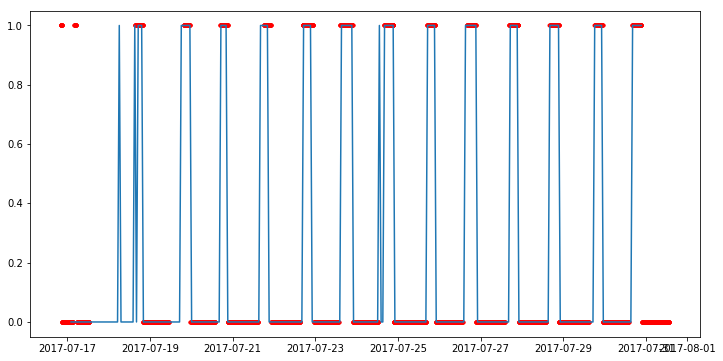

In [492]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(12, 6))
orig_obj, orig, times, predictions = objs_list[-8]
mask = (orig['fishing'] != 0)
plt.plot(orig['timestamp'][mask], orig['fishing'][mask] == 1, 'r.')
# plt.plot(orig['timestamp'], orig['inferred_setting'], 'c')
# plt.plot(orig['timestamp'], orig['inferred_setting'], '.c')
plt.plot(times, predictions)

## Determine Birdlife Ranges

In [125]:
bl_paths = (glob("../../birdlife/labeled_data/without_logbook_data/*.json") +
            glob("../../birdlife/labeled_data/with_logbook_data/*.json"))

In [126]:
RangeInfo = namedtuple("RangeInfo", ('mmsi', 'first_timestamp', 'last_timestamp'))
def extract_range_info(obj):
    first = dateutil.parser.parse(obj['timestamps'][0])
    last = dateutil.parser.parse(obj['timestamps'][-1])
    return RangeInfo(obj['mmsi'], first, last)

In [154]:
with open('birdlife_training_ranges.csv', 'w') as sink:
    sink.write('mmsi,first_time,last_time,path\n')
    for p in bl_paths:
        with open(p) as src:
            obj = json.loads(src.read())
        info = extract_range_info(obj)
        sink.write('{},{},{},{}\n'.format(info.mmsi, info.first_timestamp.isoformat(), 
                                      info.last_timestamp.isoformat(),
                                      p))